In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import time
import re
from google.colab import drive
from tqdm import tqdm
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
# 设置显示最大列数
pd.set_option('display.max_columns', None)  # None表示不限制
# 设置每列的最大显示宽度（防止换行）
pd.set_option('display.max_colwidth', None)
# 设置显示宽度（字符数）
pd.set_option('display.width', None)

In [26]:
#mentorship.csv contains mentorship relationships between researchers and has 8 variables: relationship ID (CID), mentee’s person ID, mentor’s person ID, mentorship type, the institution where the
#mentorship happened, institution MAG ID, and the start year and stop year of the interaction.
mentorship=pd.read_csv('/content/drive/MyDrive/academic_tree/data/mentorship.csv')

In [27]:
#relationship ID (CID),
mentorship
#stop year 最全611925 /743176

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear
0,2,2,3,1,"University of California, Berkeley",95457486.0,2000,2005
1,3,4,3,2,"University of California, Berkeley",95457486.0,2003,2006
2,5,6,3,1,"University of California, Berkeley",95457486.0,2002,2008
3,6,18761,9,1,"University of California, Berkeley",95457486.0,-1,1984
4,7,10,16,2,"Washington University, Saint Louis",204465549.0,-1,-1
...,...,...,...,...,...,...,...,...
743171,1784798,839679,287445,1,"University of Massachusetts, Amherst",24603500.0,-1,1991
743172,1784800,796638,839680,1,University of Wales,97429440.0,-1,1986
743173,1784802,839681,699264,1,"University of California, Santa Barbara",154570441.0,2017,-1
743174,1784803,699264,38114,1,NaN,NaN,-1,-1


In [32]:
mentorship=mentorship[ (mentorship['MentorshipType'] == 1) | (mentorship['MentorshipType'] == 2)]

In [33]:
mentorship.shape

(699091, 8)

In [34]:
mentorship['StartYear'] = mentorship['StartYear'].replace(-1, np.nan)
mentorship['StopYear'] = mentorship['StopYear'].replace(-1, np.nan)

0: Research Assistant（1.9万）

1: Graduate Student（63万，主要类型）

2: Postdoctoral（6.9万）

3: Research Scientist（7,402）

4: Collaborator（1.8万）

时间修补

先保证时间登记的是对的再说
修正时间
存在几个问题

(1)StopYear<StartYear

(2)MenteeID_type1['Diff']=MenteeID_type1.StopYear-MenteeID_type1.StartYear

MenteeID_type1=MenteeID_type1[MenteeID_type1['Diff']<=np.percentile(MenteeID_type1['Diff'], 99.5)]
#也不要一味的删掉，而是看那些异常值。进行修正


In [35]:
mask=(mentorship['StartYear'] < 1900)| (mentorship['StopYear'] < 1900)
#mentorship.loc[mask&(mentorship['StopYear'] > 1900),'StartYear']=mentorship.loc[mask&(mentorship['StopYear'] > 1900),'StopYear']-4

In [37]:
mentorship[mask].shape

(3620, 8)

In [14]:
#里面因为笔误把1973写成1873但是staring year1971,因此按照逻辑是1973,我们用样本的平均值填补
mask=(mentorship['StartYear'] < 1900)| (mentorship['StopYear'] < 1900)
mentorship.loc[(mentorship['MentorshipType']==1)&mask&(mentorship['StartYear'] > 1900)]
corrections = {
    1879: 1979,
    1700: 1970,
    1776: 1976,
    1010: 2010,
    1019: 2019
}
condition = (mentorship['MentorshipType'] == 1) & mask & (mentorship['StartYear'] > 1900)
mentorship.loc[condition, 'StopYear'] = mentorship.loc[condition, 'StopYear'].replace(corrections)

In [40]:
#2 StopYear<StartYear
#mentorship_filtered[mentorship_filtered.StopYear<mentorship_filtered.StartYear]
# 条件筛选
condition = (mentorship['StopYear'] < mentorship['StartYear'])
# 交换内容（保持列名不变）
error_records = mentorship.loc[condition]
mentorship.loc[condition, ['StartYear', 'StopYear']] = mentorship.loc[condition, ['StopYear', 'StartYear']].values

In [44]:
mentorship.shape

(699091, 8)

In [61]:
#3
mentorship['Diff']=mentorship.StopYear-mentorship.StartYear

In [64]:
mask= (mentorship["Diff"] <= np.nanpercentile(mentorship['Diff'], 95)) | (mentorship["Diff"].isna())
mentorship=mentorship[mask]

In [65]:
mentorship

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,Diff
0,2,2,3,1,"University of California, Berkeley",95457486.0,2000.0,2005.0,5.0
1,3,4,3,2,"University of California, Berkeley",95457486.0,2003.0,2006.0,3.0
2,5,6,3,1,"University of California, Berkeley",95457486.0,2002.0,2008.0,6.0
3,6,18761,9,1,"University of California, Berkeley",95457486.0,NaN,1984.0,NaN
4,7,10,16,2,"Washington University, Saint Louis",204465549.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
743170,1784794,796637,839678,1,University of Manchester,28407311.0,NaN,1983.0,NaN
743171,1784798,839679,287445,1,"University of Massachusetts, Amherst",24603500.0,NaN,1991.0,NaN
743172,1784800,796638,839680,1,University of Wales,97429440.0,NaN,1986.0,NaN
743173,1784802,839681,699264,1,"University of California, Santa Barbara",154570441.0,2017.0,NaN,NaN


In [56]:
resume_df = mentorship.sort_values(['MenteeID', 'StopYear'])

In [57]:
mentor_stats = (
    resume_df.groupby('MenteeID')['MentorshipType']
    .agg(['count', lambda x: list(x)])  # 使用list而非unique
    .reset_index()
    .rename(columns={'<lambda_0>': 'mentorship_types'})  # 重命名列
)

In [58]:
mentor_stats

,MenteeID,count,mentorship_types
0,1,2,"[1, 2]"
1,2,2,"[1, 2]"
2,3,3,"[2, 1, 1]"
3,4,3,"[1, 2, 2]"
4,5,2,"[1, 2]"
...,...,...,...
618738,839675,1,[1]
618739,839676,1,[2]
618740,839677,1,[1]
618741,839679,1,[1]


In [ ]:
mentor_stats['count'].value_counts()

,count
count,
1,572715
2,21352
3,3173
4,759
5,229
6,66
7,33
9,11
8,5


In [ ]:
mentorship_phd=mentorship[mentorship.MenteeID.isin(mentor_stats[(mentor_stats['count']==1)|(mentor_stats['count']==2)].MenteeID)]

In [ ]:
mentorship[mentorship.MenteeID.isin(mentor_stats[(mentor_stats['count']==2)].MenteeID)].sort_values('MenteeID')

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,Diff
574,643,3,595,1,Yale University,32971472.0,NaN,NaN,NaN
6,9,3,26,1,Yale University,32971472.0,NaN,NaN,NaN
951,1080,21,116,1,University of Cambridge,241749.0,NaN,NaN,NaN
1582,1776,21,201,1,University of Cambridge,241749.0,NaN,NaN,NaN
4168,4818,30,3692,1,University of Oregon,181233156.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
742996,1784415,839550,839551,1,Indiana University School of Medicine,592451.0,2018.0,2022.0,4.0
743043,1784501,839576,74609,1,California Institute of Technology,122411786.0,2015.0,2021.0,6.0
743045,1784506,839576,839578,1,New York University,57206974.0,2013.0,2015.0,2.0
743152,1784755,839670,264463,1,"University of California, Davis",84218800.0,NaN,2015.0,NaN


In [ ]:
mentorship_phd

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,Diff
0,2,2,3,1,"University of California, Berkeley",95457486.0,2000.0,2005.0,5.0
2,5,6,3,1,"University of California, Berkeley",95457486.0,2002.0,2008.0,6.0
6,9,3,26,1,Yale University,32971472.0,NaN,NaN,NaN
8,14,14,23,1,Princeton University,20089843.0,NaN,NaN,NaN
11,17,27,3,1,"University of California, Berkeley",95457486.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
743171,1784798,839679,287445,1,"University of Massachusetts, Amherst",24603500.0,NaN,1991.0,NaN
743172,1784800,796638,839680,1,University of Wales,97429440.0,NaN,1986.0,NaN
743173,1784802,839681,699264,1,"University of California, Santa Barbara",154570441.0,2017.0,NaN,NaN
743174,1784803,699264,38114,1,NaN,NaN,NaN,NaN,NaN


In [59]:
mentorship[mentorship['StartYear'].isnull() & mentorship['StopYear'].isnull()]


,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,Diff
4,7,10,16,2,"Washington University, Saint Louis",204465549.0,NaN,NaN,NaN
5,8,3,16,2,"Washington University, Saint Louis",204465549.0,NaN,NaN,NaN
6,9,3,26,1,Yale University,32971472.0,NaN,NaN,NaN
7,13,13,14,2,Massachusetts Institute of Technology,63966007.0,NaN,NaN,NaN
8,14,14,23,1,Princeton University,20089843.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
743161,1784779,839673,77416,1,NaN,NaN,NaN,NaN,NaN
743162,1784780,416525,430636,1,NaN,NaN,NaN,NaN,NaN
743167,1784788,839676,78875,2,Northeastern University,12912129.0,NaN,NaN,NaN
743168,1784789,839674,59117,2,Brandeis University,6902469.0,NaN,NaN,NaN


In [ ]:
# 找出StartYear和StopYear都为空的记录
empty_years = mentorship_phd[mentorship_phd['StartYear'].isnull() & mentorship_phd['StopYear'].isnull()]

# 查看结果
print(f"双字段缺失的记录数: {len(empty_years)}")
empty_years[['MenteeID', 'MentorshipType', 'StartYear', 'StopYear']].head()

双字段缺失的记录数: 56254


,MenteeID,MentorshipType,StartYear,StopYear
6,3,1,NaN,NaN
8,14,1,NaN,NaN
11,27,1,NaN,NaN
14,24,1,NaN,NaN
20,23,1,NaN,NaN


In [ ]:
# 获取empty_years中的所有MenteeID
ids_to_remove = empty_years['MenteeID'].unique()

# 从filled_df中排除这些ID
filtered_df = mentorship_phd[~mentorship_phd['MenteeID'].isin(ids_to_remove)]

# 验证结果
print(f"原始记录数: {len(mentorship_phd)}")
print(f"过滤后记录数: {len(filtered_df)}")
print(f"移除记录数: {len(mentorship_phd) - len(filtered_df)}")

原始记录数: 615419
过滤后记录数: 555765
移除记录数: 59654


In [ ]:
filtered_df

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,Diff
0,2,2,3,1,"University of California, Berkeley",95457486.0,2000.0,2005.0,5.0
2,5,6,3,1,"University of California, Berkeley",95457486.0,2002.0,2008.0,6.0
13,19,8,3,1,"University of California, Berkeley",95457486.0,2001.0,2006.0,5.0
18,25,5,3,1,"University of California, Berkeley",95457486.0,2003.0,2009.0,6.0
28,36,17,3,1,"University of California, Berkeley",95457486.0,1996.0,2002.0,6.0
...,...,...,...,...,...,...,...,...,...
743170,1784794,796637,839678,1,University of Manchester,28407311.0,NaN,1983.0,NaN
743171,1784798,839679,287445,1,"University of Massachusetts, Amherst",24603500.0,NaN,1991.0,NaN
743172,1784800,796638,839680,1,University of Wales,97429440.0,NaN,1986.0,NaN
743173,1784802,839681,699264,1,"University of California, Santa Barbara",154570441.0,2017.0,NaN,NaN


In [ ]:
filtered_df.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff
count,5.557650e+05,555765.000000,555765.000000,555765.0,5.241200e+05,64412.000000,544659.000000,53306.000000
mean,8.273799e+05,405439.649618,346927.305545,1.0,1.238388e+08,2001.753136,2003.224500,4.384366
std,4.419499e+05,222857.086417,222640.820319,0.0,1.652132e+08,23.982075,20.028837,1.580968
min,0.000000e+00,1.000000,1.000000,1.0,1.972200e+04,1044.000000,1049.000000,0.000000
25%,4.843440e+05,221445.000000,180918.000000,1.0,6.319074e+07,1998.000000,2002.000000,3.000000
50%,8.069680e+05,394622.000000,344024.000000,1.0,1.103780e+08,2007.000000,2007.000000,4.000000
75%,1.148725e+06,582304.000000,526380.000000,1.0,1.577252e+08,2013.000000,2011.000000,5.000000
max,1.784805e+06,839681.000000,839680.000000,1.0,3.045169e+09,2021.000000,2026.000000,9.000000


In [ ]:
filtered_df.Diff.mean()

np.float64(4.384365737440438)

In [ ]:
filtered_df=filtered_df.dropna(subset='StopYear')

In [ ]:
filtered_df['Diff']=filtered_df.StopYear-filtered_df.StartYear

/tmp/ipython-input-29-2515788923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Diff']=filtered_df.StopYear-filtered_df.StartYear


In [ ]:
filtered_df.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff
count,5.446590e+05,544659.000000,544659.000000,544659.0,5.152240e+05,53306.000000,544659.000000,53306.000000
mean,8.211678e+05,402436.868643,348923.778032,1.0,1.233244e+08,1999.270176,2003.224500,4.384366
std,4.341224e+05,219275.297191,220064.304023,0.0,1.618365e+08,25.402652,20.028837,1.580968
min,0.000000e+00,1.000000,1.000000,1.0,1.972200e+04,1044.000000,1049.000000,0.000000
25%,4.849390e+05,221920.500000,185743.000000,1.0,6.319074e+07,1995.000000,2002.000000,3.000000
50%,8.021790e+05,391147.000000,344590.000000,1.0,1.103780e+08,2005.000000,2007.000000,4.000000
75%,1.138566e+06,575843.500000,526340.000000,1.0,1.577252e+08,2011.000000,2011.000000,5.000000
max,1.784805e+06,839679.000000,839680.000000,1.0,3.045169e+09,2021.000000,2026.000000,9.000000


In [ ]:
filtered_df=filtered_df[filtered_df.StopYear<=2011]

In [ ]:
filtered_df.shape

(426088, 10)

In [ ]:
#mentorship.csv contains mentorship relationships between researchers and has 8 variables: relationship ID (CID), mentee’s person ID, mentor’s person ID, mentorship type, the institution where the
#mentorship happened, institution MAG ID, and the start year and stop year of the interaction.
mentorship=pd.read_csv('/content/drive/MyDrive/academic_tree/data/mentorship.csv')

In [ ]:
mentor_list=mentorship['MentorID'].unique()

In [ ]:
len(mentor_list)

189604

In [ ]:
filtered_df.loc[filtered_df['MenteeID'].isin(mentor_list),'retention']=1

In [ ]:
filtered_df

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,Diff,retention
0,2,2,3,1,"University of California, Berkeley",95457486.0,2000.0,2005.0,5.0,1.0
2,5,6,3,1,"University of California, Berkeley",95457486.0,2002.0,2008.0,6.0,NaN
13,19,8,3,1,"University of California, Berkeley",95457486.0,2001.0,2006.0,5.0,NaN
18,25,5,3,1,"University of California, Berkeley",95457486.0,2003.0,2009.0,6.0,1.0
28,36,17,3,1,"University of California, Berkeley",95457486.0,1996.0,2002.0,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...
743165,1784784,565901,36230,1,"Indiana University, Bloomington",592451.0,NaN,1964.0,NaN,NaN
743166,1784786,839675,36230,1,"Indiana University, Bloomington",592451.0,NaN,1979.0,NaN,NaN
743170,1784794,796637,839678,1,University of Manchester,28407311.0,NaN,1983.0,NaN,1.0
743171,1784798,839679,287445,1,"University of Massachusetts, Amherst",24603500.0,NaN,1991.0,NaN,NaN


In [ ]:
filtered_df.to_csv('/content/drive/MyDrive/academic_tree/code/phdtomentor.csv',index=False)

In [ ]:
latest_pubs=pd.read_csv("/content/drive/MyDrive/academic_tree/data/latest_pub/latest_publications_by_PID.csv")

In [ ]:
ealier_pubs=pd.read_csv("/content/drive/MyDrive/academic_tree/data/latest_pub/ealier_publications_by_PID.csv")

In [ ]:
Retention=filtered_df.merge(
    latest_pubs,
    left_on="MenteeID",
    right_on="PID",
    how='left'
    )

In [ ]:
# 创建布尔掩码：检查最新出版年份与停止年份的差值是否大于等于10
mask = (Retention['Latest_Publication_Year'] - Retention['StopYear']) >= 10

# 使用 loc 根据掩码条件为符合条件的行设置 retention2 列的值为1
Retention.loc[mask, 'retention2'] = 1

In [ ]:
Retention

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,Diff,retention,PID,Latest_Publication_Year,retention2
0,2,2,3,1,"University of California, Berkeley",95457486.0,2000.0,2005.0,5.0,1.0,2.0,2020.0,1.0
1,5,6,3,1,"University of California, Berkeley",95457486.0,2002.0,2008.0,6.0,NaN,6.0,2020.0,1.0
2,19,8,3,1,"University of California, Berkeley",95457486.0,2001.0,2006.0,5.0,NaN,8.0,2008.0,NaN
3,25,5,3,1,"University of California, Berkeley",95457486.0,2003.0,2009.0,6.0,1.0,5.0,2020.0,1.0
4,36,17,3,1,"University of California, Berkeley",95457486.0,1996.0,2002.0,6.0,NaN,17.0,2008.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426083,1784784,565901,36230,1,"Indiana University, Bloomington",592451.0,NaN,1964.0,NaN,NaN,565901.0,2017.0,1.0
426084,1784786,839675,36230,1,"Indiana University, Bloomington",592451.0,NaN,1979.0,NaN,NaN,839675.0,1988.0,NaN
426085,1784794,796637,839678,1,University of Manchester,28407311.0,NaN,1983.0,NaN,1.0,796637.0,2013.0,1.0
426086,1784798,839679,287445,1,"University of Massachusetts, Amherst",24603500.0,NaN,1991.0,NaN,NaN,839679.0,1996.0,NaN


In [ ]:
Retention[['retention','retention2']]=Retention[['retention','retention2']].fillna(0)

In [ ]:
Retention[['retention','retention2']].corr()

,retention,retention2
retention,1.000000,0.453619
retention2,0.453619,1.000000


In [ ]:
Retention.to_csv('/content/drive/MyDrive/academic_tree/results/phd/phdtomentor.csv',index=False)

开始了

In [ ]:
Retention=pd.read_csv('/content/drive/MyDrive/academic_tree/results/phd/phdtomentor.csv')

In [ ]:
Retention.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'Institution',
       'InstitutionMAGID', 'StartYear', 'StopYear', 'Diff', 'retention', 'PID',
       'Latest_Publication_Year', 'retention2'],
      dtype='object')

In [ ]:
Retention

,CID,MenteeID,MentorID,MentorshipType,Institution,InstitutionMAGID,StartYear,StopYear,Diff,retention,PID,Latest_Publication_Year,retention2
0,2,2,3,1,"University of California, Berkeley",95457486.0,2000.0,2005.0,5.0,1.0,2.0,2020.0,1.0
1,5,6,3,1,"University of California, Berkeley",95457486.0,2002.0,2008.0,6.0,0.0,6.0,2020.0,1.0
2,19,8,3,1,"University of California, Berkeley",95457486.0,2001.0,2006.0,5.0,0.0,8.0,2008.0,0.0
3,25,5,3,1,"University of California, Berkeley",95457486.0,2003.0,2009.0,6.0,1.0,5.0,2020.0,1.0
4,36,17,3,1,"University of California, Berkeley",95457486.0,1996.0,2002.0,6.0,0.0,17.0,2008.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426083,1784784,565901,36230,1,"Indiana University, Bloomington",592451.0,NaN,1964.0,NaN,0.0,565901.0,2017.0,1.0
426084,1784786,839675,36230,1,"Indiana University, Bloomington",592451.0,NaN,1979.0,NaN,0.0,839675.0,1988.0,0.0
426085,1784794,796637,839678,1,University of Manchester,28407311.0,NaN,1983.0,NaN,1.0,796637.0,2013.0,1.0
426086,1784798,839679,287445,1,"University of Massachusetts, Amherst",24603500.0,NaN,1991.0,NaN,0.0,839679.0,1996.0,0.0


In [ ]:
'''
MAG_paper=pd.read_csv('/content/drive/MyDrive/academic_tree/data/Scinet/MAGpaper.csv')
MAG_paper.rename({'PaperID':'MAGPaperID'},axis=1,inplace=True)
authorship=pd.read_csv('/content/drive/MyDrive/academic_tree/data/authorship.csv')
print(authorship.shape,len(authorship.MAGPaperID.unique()))
authorship=authorship.merge(MAG_paper,on=['MAGPaperID'])
print(authorship.shape,len(authorship.MAGPaperID.unique()))
authorship=authorship.drop(['Newsfeed_Count', 'Tweet_Count', 'NCT_Count', 'DOI', 'Date', 'DocType', 'JournalID', 'ConferenceSeriesID','WSB_mu','WSB_sigma','WSB_Cinf'],axis=1)
authorship.to_csv('/content/drive/MyDrive/academic_tree/data/iterme/authorship_metrics.csv',index=False)
'''
authorship=pd.read_csv('/content/drive/MyDrive/academic_tree/data/iterme/authorship_metrics.csv')

In [ ]:
authorship.head(2)

,PID,MAGPaperID,Year,Citation_Count,C10,Reference_Count,C5,Team_Size,Institution_Count,Disruption,Atyp_10pct_Z,Atyp_Pairs,Atyp_Median_Z,SB_B,SB_T,Patent_Count,NIH_Count,NSF_Count
0,1,1519578210,2015.0,383.0,NaN,57.0,304.0,3.0,2.0,-0.016115,-1.587336,334.0,162.543790,-1.25329,2.0,0,4,0
1,1,1972926514,2012.0,38.0,NaN,5.0,6.0,2.0,2.0,-0.013774,-27.872626,3.0,-10.887451,10.50000,4.0,1,0,0


In [ ]:
authorship.shape

(22195049, 18)

In [ ]:
Retention_=pd.read_csv('/content/drive/MyDrive/academic_tree/results/phd/phdtomentorauhtor.csv')

In [ ]:
import ast
def safe_convert(x):
    if isinstance(x, list):  # 已经是列表，直接返回
        return x
    elif isinstance(x, str):  # 如果是字符串，尝试解析
        try:
            return ast.literal_eval(x)
        except:
            return []  # 解析失败则返回空列表
    else:  # 其他情况（如 NaN、数字等）
        return []

Retention_['MenteePublishedPapers'] = Retention_['MenteePublishedPapers'].apply(safe_convert)
Retention_['MentorPublishedPapers'] = Retention_['MentorPublishedPapers'].apply(safe_convert)
Retention_['MentorPublishedPapersduring']= Retention_['MentorPublishedPapersduring'].apply(safe_convert)
Retention_['MenteePublishedPapersbefore']= Retention_['MenteePublishedPapersbefore'].apply(safe_convert)

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteePublishedPapers', 'MentorPublishedPapers', 'OverlapCount',
       'MenteePapersCount', 'MentorPapersCount', 'mentee_similarity',
       'mentor_similarity', 'Cross_Similarity', 'Citation_Count', 'C10', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'NIH_Count',
       'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B',
       'SB_T', 'Reference_Count', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'Hit_1pct_max_x', 'Hit_5pct_max_x',
       'Hit_10pct_max_x', 'C_f_mean', 'mentee_similarity2',
       'mentor_similarity2', 'Cross_Similarity2', 'mentee_similarity3',
       'mentor_similarity3', 'Cross_Similarity3', 'mentor_citation_count',
       'mentor_team_size', 'mentor_Hit_5pct', 'MentorPublishedPapersduring',
       'OverlapCountduring', 'MenteePapersduringcount',
      

In [ ]:
Retention_.drop(['mentorduring_c5',
       'MenteefurtherrPapers5_9', 'MenteefurtherrPaperscount5_9',
       'f_citation_count', 'f_c5', 'f_disruption', 'f_sb_b', 'Hit_1pct_max_y',
       'Hit_5pct_max_y', 'Hit_10pct_max_y', 'f_C_f_mean', 'PID',],axis=1,inplace=True)

In [ ]:
# 筛选Mentee在PHD学术阶段内发表的论文

merged_mentee = pd.merge(
    Retention,
    authorship,
    left_on='MenteeID',
    right_on='PID',
)

merge=merged_mentee.copy()
valid_papers = merge[
    (
        (~merge['StartYear'].isna()) &
        (merge['Year'] >= merge['StartYear']) &
        (merge['Year'] <= merge['StopYear']+2)
    ) |
    (
        merge['StartYear'].isna() &
        (merge['Year'] >= merge['StopYear'] - 4) &
        (merge['Year'] <= merge['StopYear']+2)
    )
]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MenteePublishedPapers']
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')
# 空列表填充为NaN（可选）
Retention_['MenteePublishedPapers'] = Retention_['MenteePublishedPapers'].apply(lambda x: x if isinstance(x, list) else [])


In [ ]:
#mentee在PHD之前发表文章
merged_mentee = pd.merge(
    Retention_[['CID','MenteeID','StartYear','StopYear']],
    authorship,
    left_on='MenteeID',
    right_on='PID',
)
merge=merged_mentee.copy()
valid_papers = merge[
    (
        (~merge['StartYear'].isna()) &
        (merge['Year'] >= merge['StartYear']-3) &
        (merge['Year'] < merge['StartYear'])
    ) |
    (
        merge['StartYear'].isna() &
        (merge['Year'] >= merge['StopYear'] - 8) &
        (merge['Year'] < merge['StopYear']-4)
    )
]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MenteePublishedPapersbefore']
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')
# 空列表填充为NaN（可选）
Retention_['MenteePublishedPapersbefore'] = Retention_['MenteePublishedPapersbefore'].apply(lambda x: x if isinstance(x, list) else [])
Retention_['MenteePaperscountbefore'] = Retention_['MenteePublishedPapersbefore'].apply(len)

In [ ]:
Retention_[['MenteePaperscountbefore','MenteePublishedPapersbefore']]

,MenteePaperscountbefore,MenteePublishedPapersbefore
0,0,[]
1,0,[]
2,0,[]
3,0,[]
4,2,"[2011274756, 2045445907]"
...,...,...
423376,0,[]
423377,0,[]
423378,0,[]
423379,0,[]


In [ ]:
# 筛选Mentor在学生读PHD之前发表的论文
merged_mentor = pd.merge(
    Retention_,
    authorship,
    left_on='MentorID',
    right_on='PID',
)


merge=merged_mentor
valid_papers = merge[
    (
        (~merge['StartYear'].isna()) &
        (merge['Year'] >= merge['StartYear']-3) &
        (merge['Year'] < merge['StartYear'])
    ) |
    (
        merge['StartYear'].isna() &
        (merge['Year'] >= merge['StopYear'] - 8) &
        (merge['Year'] < merge['StopYear']-4)
    )
]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MentorPublishedPapers']

# 合并回原表
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')

# 空列表填充为NaN（可选）
Retention_['MentorPublishedPapers'] = Retention_['MentorPublishedPapers'].apply(lambda x: x if isinstance(x, list) else [])

In [ ]:
Retention_.drop('MentorPublishedPapers_5',axis=1)

In [ ]:
# 筛选Mentor在学生读PHD之前发表的论文(t-5,t)
merged_mentor = pd.merge(
    Retention_[['CID','MentorID','StartYear','StopYear']],
    authorship,
    left_on='MentorID',
    right_on='PID',
)


merge=merged_mentor
valid_papers = merge[
    (
        (~merge['StartYear'].isna()) &
        (merge['Year'] >= merge['StartYear']-5) &
        (merge['Year'] < merge['StartYear'])
    ) |
    (
        merge['StartYear'].isna() &
        (merge['Year'] >= merge['StopYear'] - 10) &
        (merge['Year'] < merge['StopYear']-4)
    )
]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MentorPublishedPapers_5']

# 合并回原表
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')

# 空列表填充为NaN（可选）
Retention_['MentorPublishedPapers_5'] = Retention_['MentorPublishedPapers_5'].apply(lambda x: x if isinstance(x, list) else [])

In [ ]:
# 筛选Mentor在自己学生mentee读PHD的时候发表的论文
merged_mentor = pd.merge(
    Retention_[['CID','MentorID','StartYear','StopYear']],
    authorship,
    left_on='MentorID',
    right_on='PID',
)
merge=merged_mentor
valid_papers = merge[
    (
        (~merge['StartYear'].isna()) &
        (merge['Year'] >= merge['StartYear']) &
        (merge['Year'] <= merge['StopYear']+2)
    ) |
    (
        merge['StartYear'].isna() &
        (merge['Year'] >= merge['StopYear'] - 4) &
        (merge['Year'] <= merge['StopYear'] + 2)
    )
]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MentorPublishedPapersduring']
# 合并回原表
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')
# 空列表填充为NaN（可选）
Retention_['MentorPublishedPapersduring'] = Retention_['MentorPublishedPapersduring'].apply(lambda x: x if isinstance(x, list) else [])

Retention_['OverlapCountduring'] = Retention_.apply(lambda row: len(set(row['MenteePublishedPapers']) & set(row['MentorPublishedPapersduring'])),axis=1)
Retention_['MenteePapersduringcount'] = Retention_['MenteePublishedPapers'].apply(len)
Retention_['MentorPapersduringcount'] = Retention_['MentorPublishedPapersduring'].apply(len)

Retention_['MenteeColduringRatio'] = Retention_['OverlapCountduring'] / Retention_['MenteePapersduringcount']
# 计算 Mentor 视角的重合比例
Retention_['MentorColduringRatio'] = Retention_['OverlapCountduring'] / Retention_['MentorPapersduringcount']
# 处理除零错误（如果 MenteePapersCount 或 MentorPapersCount 为 0）
Retention_['MenteeColduringRatio'] = Retention_['MenteeColduringRatio'].fillna(0)
Retention_['MentorColduringRatio'] = Retention_['MentorColduringRatio'].fillna(0)

In [ ]:
Retention_[['OverlapCountduring','MenteePublishedPapers','MentorPublishedPapersduring','MenteePapersduringcount','MentorPapersduringcount','MenteeColduringRatio','MentorColduringRatio']].head(1)

,OverlapCountduring,MenteePublishedPapers,MentorPublishedPapersduring,MenteePapersduringcount,MentorPapersduringcount,MenteeColduringRatio,MentorColduringRatio
0,3,"[2025610049, 2028047007, 2060095666, 2102190536, 2114854701, 2150438109, 2165789639, 2592168570]","[132109560, 1844800426, 1965274605, 1967303766, 1986412697, 2028047007, 2057601421, 2058670155, 2061209400, 2074968303, 2076398027, 2076477106, 2098531347, 2102662817, 2110333622, 2114219449, 2114854701, 2116783544, 2138727818, 2141865020, 2170556807, 2171525519, 2481926156, 2592168570]",8,24,0.375,0.125


In [ ]:
Retention_.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff,retention,retention2,...,Mentee_SpecterDistance_scaled,Mentor_SpecterDistance_scaled,Mentee_topics_d,Mentor_topics_d,Mentee_Unique_Topics_d,Mentor_Unique_Topics_d,Mentee_subtopics_d,Mentor_subtopics_d,Mentee_Unique_subtopics_d,Mentor_Unique_subtopic_d
count,4.233810e+05,423381.000000,423381.000000,423381.0,4.028250e+05,30957.000000,423381.000000,30957.000000,423381.000000,423381.000000,...,252707.000000,372758.000000,423381.000000,423381.000000,423381.000000,423381.000000,423381.000000,423381.000000,423381.000000,423381.000000
mean,8.004539e+05,390698.390596,347555.275523,1.0,1.220220e+08,1992.789644,2001.491501,4.330523,0.120357,0.267426,...,0.175829,0.097012,3.232875,25.338827,0.889842,2.530796,4.987612,38.610424,2.236045,8.897558
std,4.267457e+05,215006.321822,219625.742179,0.0,1.584637e+08,14.920964,13.760816,1.578645,0.325379,0.442617,...,0.124829,0.082787,7.174939,38.378775,1.144025,2.165313,11.639199,60.188627,3.256465,8.754527
min,1.000000e+00,1.000000,3.000000,1.0,2.159270e+05,1897.000000,1900.000000,0.000000,0.000000,0.000000,...,0.000048,0.000049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.669890e+05,212489.000000,185648.000000,1.0,6.319074e+07,1987.000000,2001.000000,3.000000,0.000000,0.000000,...,0.083123,0.053211,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.000000
50%,7.871950e+05,381931.000000,344523.000000,1.0,1.076392e+08,1997.000000,2005.000000,4.000000,0.000000,0.000000,...,0.134821,0.072165,1.000000,12.000000,1.000000,2.000000,1.000000,18.000000,1.000000,7.000000
75%,1.112665e+06,561849.000000,532897.000000,1.0,1.557813e+08,2003.000000,2008.000000,5.000000,0.000000,1.000000,...,0.236016,0.103080,4.000000,33.000000,1.000000,4.000000,6.000000,50.000000,4.000000,13.000000
max,1.784800e+06,839679.000000,839680.000000,1.0,3.045169e+09,2011.000000,2011.000000,9.000000,1.000000,1.000000,...,0.936167,0.950170,501.000000,893.000000,19.000000,18.000000,1091.000000,1453.000000,101.000000,131.000000


筛选mentee 毕业7-10年发表的文章

筛选mentee 毕业4-7年发表的文章

In [ ]:
Retention_=pd.read_csv('/content/drive/MyDrive/academic_tree/combined_phd_postdoc.csv')

In [ ]:
authorship=pd.read_csv('/content/drive/MyDrive/academic_tree/data/iterme/authorship_metrics.csv')

In [ ]:
Retention_.columns

Index(['cid', 'menteeid', 'mentorid', 'institutionmagid', 'startyear',
       'stopyear', 'diff', 'retention', 'retention2', 'menteepaperscount_d',
       ...
       'race_dummy', 'ranking', 'menteepaperscount_d_w',
       'cross_similarity_spec_5', 'phd', 'graduation_cohort', 'lncareer_age_w',
       'lnmenteepaperscount_d', 'f_disruption_14', 'f_disruption_47'],
      dtype='object', length=102)

In [ ]:
merged_mentor = pd.merge(
    Retention_[['cid','menteeid','startyear','stopyear']],
    authorship,
    left_on='menteeid',
    right_on='PID',
)

In [ ]:
merge=merged_mentor
valid_papers = merge[((merge['Year'] >= merge['stopyear']+7) & (merge['Year'] <= merge['stopyear']+10)) ]


In [ ]:
result_metrics = valid_papers.groupby('cid')['Disruption'].mean().reset_index().rename(columns={
                      'Disruption': 'f_disruption_710',})

#Retention_ = pd.merge(Retention_, result_metrics, on='cid', how='left')

In [ ]:
Retention_ = pd.merge(Retention_, result_metrics, on='cid', how='left')

In [ ]:
Retention_[['menteefurtherrpaperscount1_4','f_disruption_14','ln_f_c_f_mean1_4']].describe()

,menteefurtherrpaperscount1_4,f_disruption_14,ln_f_c_f_mean1_4
count,453802.000000,195279.000000,207973.000000
mean,3.061113,-0.002451,1.007375
std,7.601221,0.061300,0.636839
min,0.000000,-1.000000,0.000000
25%,0.000000,-0.003301,0.549230
50%,0.000000,-0.001095,0.923628
75%,3.000000,-0.000073,1.360338
max,536.000000,0.991870,6.983005


In [ ]:
Retention_[['menteefurtherrpaperscount7_10','f_disruption_710','ln_f_c_f_mean7_10']].describe()

,menteefurtherrpaperscount7_10,f_disruption_710,ln_f_c_f_mean7_10
count,453802.000000,134220.000000,144294.000000
mean,3.977243,-0.001432,0.997202
std,11.657962,0.055257,0.620374
min,0.000000,-1.000000,0.000000
25%,0.000000,-0.002400,0.569895
50%,0.000000,-0.000755,0.925785
75%,2.000000,-0.000042,1.330180
max,1365.000000,0.997196,6.432138


In [ ]:
Retention_.head(1)

,cid,menteeid,mentorid,institutionmagid,startyear,stopyear,diff,retention,retention2,menteepaperscount_d,mentorpaperscount_b,citation_count,c10,c5,team_size,institution_count,disruption,nih_count,nsf_count,atyp_10pct_z,atyp_median_z,patent_count,sb_b,sb_t,reference_count,researcharea,magauthorid,gender,race,jsd,jsd_sub,hit_1pct_max,hit_5pct_max,hit_10pct_max,c_f_mean,mentee_similarity_spec,mentor_similarity_spec,cross_similarity_spec,mentee_similarity_nor,mentor_similarity_nor,cross_similarity_nor,mentor_citation_count_b,mentor_team_size_b,mentor_hit_5pct_b,overlapcountduring,mentorpapersduringcount,menteecolduringratio,mentorcolduringratio,menteepaperscountbefore,mentee_citation_count_before,jsd_before,mentee_specterdistance_scaled,mentor_specterdistance_scaled,mentee_topics_d,mentor_topics_d,mentee_unique_topics_d,mentor_unique_topics_d,mentee_subtopics_d,mentor_subtopics_d,mentee_unique_subtopics_d,mentor_unique_subtopic_d,ealier_publication_year,menteefurtherrpaperscount1_4,menteefurtherrpaperscount4_7,menteefurtherrpaperscount7_10,lncitation,lnc5,lnc10,lnc_f_mean,cohort_id,funding,lnmentor_citation_count_b,lnmentee_citation_count_before,lnpatent_count,lnteam_size,spec2,total_mentees,cum_retention,career_age_w,ln_f_citation_count_14,ln_f_c5_14,ln_f_c_f_mean1_4,ln_f_citation_count_47,ln_f_c5_47,ln_f_c_f_mean4_7,ln_f_citation_count_710,ln_f_c5_710,ln_f_c_f_mean7_10,stem,topic_deviation,num_mentors,menteeovermentor,race_dummy,ranking,menteepaperscount_d_w,cross_similarity_spec_5,phd,graduation_cohort,lncareer_age_w,lnmenteepaperscount_d,f_disruption_14,f_disruption_47,f_disruption_710
0,1,1,3,95457486.0,1998.0,2005,7.0,1,1,12,6,145.28947,88.078949,40.236843,3.605263,1.342857,-0.003078,0.789474,0.157895,-6.590457,89.735229,0.078947,2.284594,6.28125,66.763161,neuro,2.171828e+09,man,White,0.094469,0.103537,1,1,1,4.860495,0.852039,0.844004,0.825042,0.126599,0.229891,0.098119,149.33333,3.444444,1,8,28,0.666667,0.285714,1,667.0,0.318257,0.03879,0.043112,12,26,4,7,21,45,9,12,1990.0,14,14,18,4.985588,3.719332,4.489523,1.768234,11,0.947368,5.012855,6.504288,0.075986,1.5272,0.680694,7,2,15.0,4.740853,3.701565,1.810978,4.606835,4.013978,1.756468,4.651638,4.21573,1.898596,1,0.333333,1,-3,1.0,1.0,12,0.824302,1,2005-,2.772589,2.564949,-0.003023,-0.003934,-0.00452


In [ ]:
Retention_.to_csv('/content/drive/MyDrive/academic_tree/combined_phd_postdoc.csv',index=False)

In [ ]:
# StopYear没有缺失的
#1-4年MenteefurtherrPapers1_4
#4-7年MenteefurtherrPapers4_7
#7-10年MenteefurtherrPapers7_10
merged_mentor = pd.merge(
    Retention_[['CID','MenteeID','StartYear','StopYear']],
    authorship,
    left_on='MenteeID',
    right_on='PID',
)
merge=merged_mentor
valid_papers = merge[((merge['Year'] >= merge['StopYear']+7) & (merge['Year'] <= merge['StopYear']+10)) ]
paper_lists = valid_papers.groupby('CID')['MAGPaperID'].apply(list).reset_index()
paper_lists.columns = ['CID', 'MenteefurtherrPapers7_10']
# 合并回原表
Retention_ = pd.merge(Retention_, paper_lists, on='CID', how='left')
# 空列表填充为NaN（可选）
Retention_['MenteefurtherrPapers7_10'] = Retention_['MenteefurtherrPapers7_10'].apply(lambda x: x if isinstance(x, list) else [])
Retention_['MenteefurtherrPaperscount7_10']=Retention_['MenteefurtherrPapers7_10'].apply(len)

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteePublishedPapers', 'MentorPublishedPapers', 'OverlapCount',
       'MenteePapersCount', 'MentorPapersCount', 'mentee_similarity',
       'mentor_similarity', 'Cross_Similarity', 'Citation_Count', 'C10', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'NIH_Count',
       'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B',
       'SB_T', 'Reference_Count', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'Hit_1pct_max_x', 'Hit_5pct_max_x',
       'Hit_10pct_max_x', 'C_f_mean', 'mentee_similarity2',
       'mentor_similarity2', 'Cross_Similarity2', 'mentee_similarity3',
       'mentor_similarity3', 'Cross_Similarity3', 'mentor_citation_count',
       'mentor_team_size', 'mentor_Hit_5pct', 'MentorPublishedPapersduring',
       'OverlapCountduring', 'MenteePapersduringcount',
      

In [ ]:
Retention_[['MenteefurtherrPapers4_7', 'MenteefurtherrPaperscount4_7']]

,MenteefurtherrPapers4_7,MenteefurtherrPaperscount4_7
0,"[1538084273, 1971893369, 1972926514, 199189267...",23
1,"[1922655562, 2019384989, 2162741763, 253955957...",5
2,[],0
3,"[1425539977, 1434042695, 1610786479, 164608459...",33
4,[1589049074],1
...,...,...
423376,"[2037456940, 2067367447, 2109756300]",3
423377,[2021046409],1
423378,"[2109337150, 2153932199]",2
423379,[2040810457],1


In [ ]:
Retention_.to_csv('/content/drive/MyDrive/academic_tree/results/phd/phdtomentorauhtor.csv',index=False)

In [ ]:
Retention_.to_csv('/content/data.csv',index=False)

In [ ]:
valid_rows=Retention_[Retention_['PublishedPapers'].str.len() > 0]

In [ ]:
valid_rows

In [ ]:
valid_rows.describe()

,CID,MenteeID,MentorID,MentorshipType,InstitutionMAGID,StartYear,StopYear,Diff,retention,PID,Latest_Publication_Year,retention2
count,3.136540e+05,313654.000000,313654.000000,313654.0,3.027250e+05,21152.000000,313654.000000,21152.000000,313654.000000,205801.000000,205801.000000,313654.000000
mean,7.769506e+05,381861.927487,334888.116023,1.0,1.194974e+08,1993.792124,2002.869904,4.531534,0.098283,369629.438229,2012.475348,0.283475
std,4.166498e+05,211914.061414,215559.731596,0.0,1.493221e+08,12.926908,11.040572,1.469642,0.297698,222391.355146,8.738287,0.450686
min,1.000000e+00,1.000000,3.000000,1.0,2.417490e+05,1858.000000,1801.000000,0.000000,0.000000,1.000000,1888.000000,0.000000
25%,4.398365e+05,200745.250000,174209.000000,1.0,6.319074e+07,1988.000000,2002.000000,4.000000,0.000000,161168.000000,2007.000000,0.000000
50%,7.709000e+05,376092.500000,335566.000000,1.0,1.076392e+08,1998.000000,2005.000000,5.000000,0.000000,373640.000000,2014.000000,0.000000
75%,1.082584e+06,548676.000000,516101.750000,1.0,1.545704e+08,2003.000000,2009.000000,5.000000,0.000000,544201.000000,2020.000000,1.000000
max,1.784798e+06,839679.000000,839678.000000,1.0,3.045169e+09,2011.000000,2011.000000,9.000000,1.000000,839679.000000,2022.000000,1.000000


In [ ]:
import pandas as pd

# 1. 确定 StopYear 的范围
max_year = int(valid_rows['StopYear'].max())

# 2. 创建 10 年分组
bins = list(range(1900, max_year + 10, 10))
labels = [f"{start}-{start+10}" for start in bins[:-1]]

valid_rows['YearGroup'] = pd.cut(
    valid_rows['StopYear'],
    bins=bins,
    labels=labels,
    right=False
)

# 3. 计算每组的论文数量均值
valid_rows['PaperCount'] = valid_rows['PublishedPapers'].apply(len)
result = valid_rows.groupby('YearGroup')['PaperCount'].mean().reset_index()
result.columns = ['YearRange', 'AvgPaperCount']

print(result)

    YearRange  AvgPaperCount
0   1900-1910      13.930380
1   1910-1920      12.341121
2   1920-1930      14.515658
3   1930-1940      14.582451
4   1940-1950      12.440748
5   1950-1960      13.067836
6   1960-1970      13.511966
7   1970-1980      17.573074
8   1980-1990      22.009588
9   1990-2000      27.487990
10  2000-2010      25.796418
11  2010-2020      31.743736


<ipython-input-19-1523066550>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_rows['YearGroup'] = pd.cut(
<ipython-input-19-1523066550>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_rows['PaperCount'] = valid_rows['PublishedPapers'].apply(len)
<ipython-input-19-1523066550>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and si

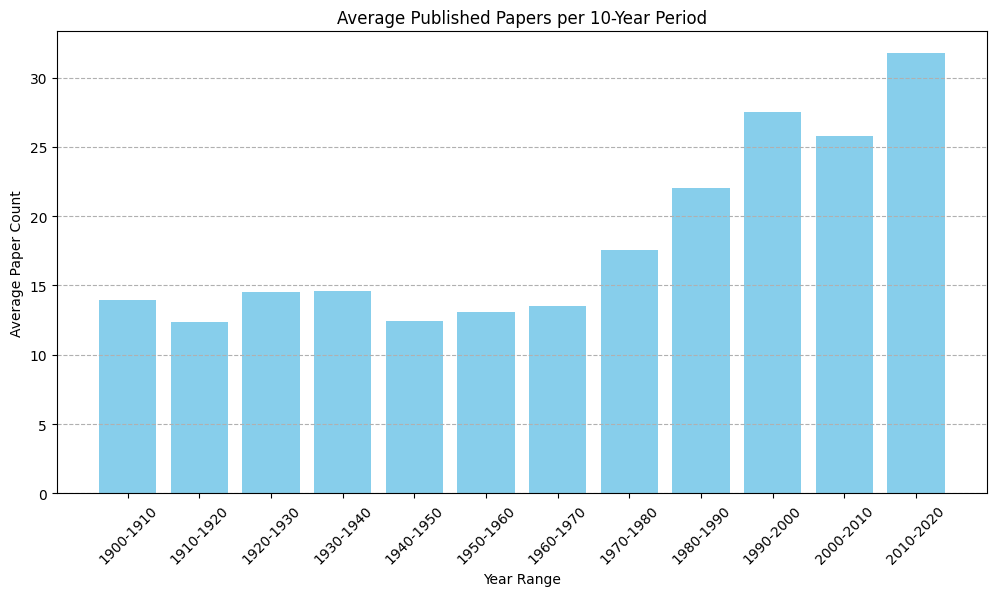

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 计算10年分组和论文数量（假设已按之前方法生成result表）
plt.figure(figsize=(12, 6))
plt.bar(result['YearRange'], result['AvgPaperCount'], color='skyblue')
plt.xlabel('Year Range')
plt.ylabel('Average Paper Count')
plt.title('Average Published Papers per 10-Year Period')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

查看coauthor的数量

In [ ]:
Retention_=pd.read_csv('/content/drive/MyDrive/academic_tree/results/phd/phdtomentorauhtor.csv')

In [ ]:
Retention_.shape

(423381, 55)

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteePublishedPapers', 'MentorPublishedPapers', 'OverlapCount',
       'MenteePapersCount', 'MentorPapersCount', 'mentee_similarity',
       'mentor_similarity', 'Cross_Similarity', 'Citation_Count', 'C10', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'NIH_Count',
       'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B',
       'SB_T', 'Reference_Count', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'Hit_1pct_max', 'Hit_5pct_max',
       'Hit_10pct_max', 'C_f_mean', 'mentee_similarity2', 'mentor_similarity2',
       'Cross_Similarity2', 'mentee_similarity3', 'mentor_similarity3',
       'Cross_Similarity3', 'mentor_citation_count', 'mentor_team_size',
       'mentor_Hit_5pct', 'MentorPublishedPapersduring', 'OverlapCountduring',
       'MenteePapersduringcount', 'MentorPaper

In [ ]:
import ast
def safe_convert(x):
    if isinstance(x, list):  # 已经是列表，直接返回
        return x
    elif isinstance(x, str):  # 如果是字符串，尝试解析
        try:
            return ast.literal_eval(x)
        except:
            return []  # 解析失败则返回空列表
    else:  # 其他情况（如 NaN、数字等）
        return []
#MenteePublishedPapers Mentee在PHD阶段发表的文章
#MentorPublishedPapers Mentor在menteePHD阶段t-3到t发表的文章
#MentorPublishedPapersduring Mentor在menteePHD阶段发表的文章
#MenteePublishedPapersbefore MenteePHD阶段t-3到t发表的文章
Retention_['MenteePublishedPapers'] = Retention_['MenteePublishedPapers'].apply(safe_convert)
Retention_['MentorPublishedPapers'] = Retention_['MentorPublishedPapers'].apply(safe_convert)
Retention_['MentorPublishedPapersduring']= Retention_['MentorPublishedPapersduring'].apply(safe_convert)
Retention_['MenteePublishedPapersbefore']= Retention_['MenteePublishedPapersbefore'].apply(safe_convert)

In [ ]:
from scipy import sparse
data = np.load('/content/drive/MyDrive/academic_tree/data/tfidf/paper_tfidf.npz')
tfidf_csr = sparse.csr_matrix(
    (data['data'], data['indices'], data['indptr']),
    shape=data['shape']
)

paper_tfidf_MAGPaperID = pd.read_csv(
    '/content/drive/MyDrive/academic_tree/data/tfidf/paper_tfidf_MAGPaperID.txt',
    compression='gzip',
    header=None,  # 无列名
    names=['MAGPaperID']  # 自定义列名
)
paper_id_mapping = paper_tfidf_MAGPaperID.to_dict()  # {索引: 值}
reversed_dict = {v: k for k, v in paper_id_mapping['MAGPaperID'].items()}

新增一个归一化处理

In [ ]:
def normalize_vector(vec):
    """归一化单个向量"""
    if isinstance(vec, sparse.csr_matrix):
        # 处理稀疏向量
        norm = np.linalg.norm(vec.data)
        if norm > 0:
            return vec / norm
        return vec
    else:
        # 处理密集向量
        norm = np.linalg.norm(vec)
        if norm > 0:
            return vec / norm
        return vec

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def get_paper_indices(paper_ids):
    return [reversed_dict[pid] for pid in paper_ids]

def calc_phase_similarity(paper_list):
    """计算一个阶段论文集合的余弦相似度均值"""
    if len(paper_list) < 2:
        return np.nan  # 不足2篇无法计算

    # 获取所有论文的TF-IDF向量
    indices = get_paper_indices(paper_list)
    vectors = tfidf_csr[indices]
    normalized_vectors = []
    for vec in vectors:
        normalized_vectors.append(normalize_vector(vec))
    if isinstance(vectors, sparse.csr_matrix):
        normalized_vectors = sparse.vstack(normalized_vectors)
    # 计算全连接相似度矩阵
    #sim_matrix = cosine_similarity(vectors)
    sim_matrix = cosine_similarity(normalized_vectors)
    # 返回非对角元素的均值（排除自相似）
    return np.tril(sim_matrix, k=-1).sum() / (len(paper_list)*(len(paper_list)-1)/2)

from tqdm import tqdm
Retention_['mentee_similarity3'] = [calc_phase_similarity(papers) for papers in tqdm(Retention_['MenteePublishedPapers'])]
# 自定义进度条外观
Retention_['mentor_similarity3'] = [
    calc_phase_similarity(papers)
    for papers in tqdm(
        Retention_['MentorPublishedPapers'],
        desc="计算相似度",
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}",
        mininterval=10  # 每2秒刷新一次
    )
]

from sklearn.preprocessing import normalize
from tqdm import tqdm
def calc_cross_similarity(mentee_ids, mentor_ids):
    # 获取有效论文的索引
    phd_indices = [reversed_dict[pid] for pid in mentee_ids]
    postdoc_indices = [reversed_dict[pid] for pid in mentor_ids]

    if not phd_indices or not postdoc_indices:
        return np.nan

    # 获取TF-IDF向量
    #phd_vectors = tfidf_csr[phd_indices]
    #postdoc_vectors = tfidf_csr[postdoc_indices]


    phd_vectors = normalize(tfidf_csr[phd_indices], norm='l2', axis=1)
    postdoc_vectors = normalize(tfidf_csr[postdoc_indices], norm='l2', axis=1)

    # 计算跨列表相似度矩阵
    sim_matrix = phd_vectors.dot(postdoc_vectors.T)

    #sim_matrix = cosine_similarity(phd_vectors, postdoc_vectors)

    # 返回所有组合的均值
    return  sim_matrix.mean()

from tqdm.notebook import tqdm  # 使用Jupyter风格的进度条
import pandas as pd


def apply_with_progress(df, func, axis=1, desc="Processing"):
    tqdm.pandas(desc=desc, leave=False)  # leave=False表示完成后不保留进度条
    return df.progress_apply(func, axis=axis)
print("开始计算跨列表相似度...")
Retention_['Cross_Similarity3'] = apply_with_progress(
    Retention_,
    lambda row: calc_cross_similarity(row['MenteePublishedPapers'], row['MentorPublishedPapers']),
    desc="计算跨列表相似度"
)

In [ ]:
Retention_.to_csv('/content/drive/MyDrive/academic_tree/results/phd/phdtomentorauhtor.csv',index=False)

In [ ]:
Retention_.to_csv('/content/data.csv',index=False)

In [ ]:
expanded_df = Retention_.explode('MenteePublishedPapers')

In [ ]:
expanded_df.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'Institution',
       'InstitutionMAGID', 'StartYear', 'StopYear', 'Diff', 'retention', 'PID',
       'Latest_Publication_Year', 'retention2', 'MenteePublishedPapers',
       'MentorPublishedPapers', 'OverlapCount', 'MenteePapersCount',
       'MentorPapersCount', 'MenteeOverlapRatio', 'MentorOverlapRatio',
       'mentee_similarity', 'mentor_similarity', 'Cross_Similarity'],
      dtype='object')

In [ ]:
expanded_df.shape

(1591058, 55)

In [ ]:
authorship.columns

Index(['PID', 'MAGPaperID', 'Year', 'Citation_Count', 'C10', 'Reference_Count',
       'C5', 'Team_Size', 'Institution_Count', 'Disruption', 'Atyp_10pct_Z',
       'Atyp_Pairs', 'Atyp_Median_Z', 'SB_B', 'SB_T', 'Patent_Count',
       'NIH_Count', 'NSF_Count'],
      dtype='object')

In [ ]:
merged_df = pd.merge(
    expanded_df[['CID','MenteePublishedPapers']],
    authorship,
    left_on='MenteePublishedPapers',
    right_on='MAGPaperID',
    how='left'
)

# 步骤3：计算各项指标的平均值
metrics = ['Citation_Count', 'C10', 'C5', 'Team_Size',
           'Institution_Count', 'Disruption', 'NIH_Count', 'NSF_Count','Atyp_10pct_Z','Atyp_Median_Z','Patent_Count',  'SB_B', 'SB_T','Reference_Count']
result_metrics = merged_df.groupby('CID')[metrics].mean().reset_index()

In [ ]:
#导师在Mentee受训t-3到t年总被引
#导师在Mentee受训t-3到t年是否发表过5%的文章
expanded_df = Retention_.explode('MentorPublishedPapers')
print(expanded_df.shape)
merged_df = pd.merge(
    expanded_df[['CID','MentorPublishedPapers']],
    authorship,
    left_on='MentorPublishedPapers',
    right_on='MAGPaperID',
    how='left'
)
# 步骤3：计算各项指标的平均值
metrics = ['Citation_Count', 'Team_Size']
result_metrics = (merged_df.groupby('CID')[metrics].mean().reset_index().rename(columns={
                      'Citation_Count': 'mentor_citation_count_b',
                      'Team_Size': 'mentor_team_size_b'
                  }))

(4610072, 61)


In [ ]:
#MenteefurtherrPapers
#未来的metrics
#MenteefurtherrPapers1_4
#MenteefurtherrPapers4_7
#MenteefurtherrPapers7_10
expanded_df = Retention_.explode('MenteefurtherrPapers7_10')
print(expanded_df.shape)
merged_df = pd.merge(
    expanded_df[['CID','MenteefurtherrPapers7_10']],
    authorship,
    left_on='MenteefurtherrPapers7_10',
    right_on='MAGPaperID',
    how='left'
)
# 步骤3：计算各项指标的平均值
metrics = ['Citation_Count','C5']
result_metrics = (merged_df.groupby('CID')[metrics].mean().reset_index().rename(columns={
                      'Citation_Count': 'f_citation_count_710',
                      'C5':'f_c5_710',}))
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

(1776181, 85)


In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteePublishedPapers', 'MentorPublishedPapers', 'OverlapCount',
       'MenteePapersCount', 'MentorPapersCount', 'mentee_similarity',
       'mentor_similarity', 'Cross_Similarity', 'Citation_Count', 'C10', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'NIH_Count',
       'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B',
       'SB_T', 'Reference_Count', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'Hit_1pct_max_x', 'Hit_5pct_max_x',
       'Hit_10pct_max_x', 'C_f_mean', 'mentee_similarity2',
       'mentor_similarity2', 'Cross_Similarity2', 'mentee_similarity3',
       'mentor_similarity3', 'Cross_Similarity3', 'mentor_citation_count',
       'mentor_team_size', 'mentor_Hit_5pct', 'MentorPublishedPapersduring',
       'OverlapCountduring', 'MenteePapersduringcount',
      

In [ ]:
result_metrics.head(3)

,CID,mentor_citation_count,mentor_team_size
0,1,149.333333,3.444444
1,2,142.692308,3.000000
2,5,224.333333,3.333333


In [ ]:
Retention_[['CID','mentor_citation_count','mentor_team_size']].head(3)

,CID,mentor_citation_count,mentor_team_size
0,2,142.692308,3.000000
1,5,224.333333,3.333333
2,19,187.850000,2.700000


In [ ]:
#mentee在PHD之前发表文章citation平均被引
expanded_df = Retention_.explode('MenteePublishedPapersbefore')
print(expanded_df.shape)
merged_df = pd.merge(
    expanded_df[['CID','MenteePublishedPapersbefore']],
    authorship,
    left_on='MenteePublishedPapersbefore',
    right_on='MAGPaperID',
    how='left'
)
# 步骤3：计算各项指标的平均值
metrics = ['Citation_Count']
result_metrics = (merged_df.groupby('CID')[metrics].mean().reset_index().rename(columns={
                      'Citation_Count': 'mentee_citation_count_before' }))
result_metrics['mentee_citation_count_before'].fillna(0,inplace=True)

(473045, 61)


In [ ]:
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteePublishedPapers', 'MentorPublishedPapers', 'OverlapCount',
       'MenteePapersCount', 'MentorPapersCount', 'mentee_similarity',
       'mentor_similarity', 'Cross_Similarity', 'Citation_Count', 'C10', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'NIH_Count',
       'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B',
       'SB_T', 'Reference_Count', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'Hit_1pct_max_x', 'Hit_5pct_max_x',
       'Hit_10pct_max_x', 'C_f_mean', 'mentee_similarity2',
       'mentor_similarity2', 'Cross_Similarity2', 'mentee_similarity3',
       'mentor_similarity3', 'Cross_Similarity3', 'mentor_citation_count',
       'mentor_team_size', 'mentor_Hit_5pct', 'MentorPublishedPapersduring',
       'OverlapCountduring', 'MenteePapersduringcount',
      

Researcher level

In [ ]:
researcher=pd.read_csv('/content/drive/MyDrive/academic_tree/data/researcher.csv')

In [ ]:
researcher.columns

Index(['PID', 'FirstName', 'MiddleName', 'LastName', 'Institution',
       'InstitutionMAGID', 'ResearchArea', 'MAGAuthorID', 'gender', 'race'],
      dtype='object')

In [ ]:
researcher=researcher.drop([ 'FirstName', 'MiddleName', 'LastName', 'Institution', 'InstitutionMAGID'],axis=1)

In [ ]:
df=pd.merge(
    Retention_,
    researcher,
    left_on='MenteeID',
    right_on='PID',
)


In [ ]:
df=df[df.StopYear>=1900]

In [ ]:
df.shape

(423381, 42)

JSD similarity

In [ ]:
field=pd.read_csv('/content/drive/MyDrive/academic_tree/data/Scinet/SciSciNet_Fields.tsv',sep='\t')
field.loc[field.Field_Type=='Top','new_FieldID'] = range(0, 19)
field.loc[field.Field_Type=='Sub','new_FieldID'] = range(0, 292)
mappingtopfield_dict = field[field.Field_Type=='Top'].set_index('FieldID')['new_FieldID'].to_dict()
mappingsubfield_dict = field[field.Field_Type=='Sub'].set_index('FieldID')['new_FieldID'].to_dict()

In [ ]:
paper_field=pd.read_csv('/content/drive/MyDrive/academic_tree/data/Scinet/MAGpaper_fields.csv')
paper_field.drop([ 'hit_1_records', 'hit_5_records', 'hit_10_records'],axis=1,inplace=True)

In [ ]:
import ast
def safe_convert(x):
    if isinstance(x, list):  # 已经是列表，直接返回
        return x
    elif isinstance(x, str):  # 如果是字符串，尝试解析
        try:
            return ast.literal_eval(x)
        except:
            return []  # 解析失败则返回空列表
    else:  # 其他情况（如 NaN、数字等）
        return []
paper_field['Sub_fieldID'] = paper_field['Sub_fieldID'].apply(safe_convert)
paper_field['Top_fieldID'] = paper_field['Top_fieldID'].apply(safe_convert)

In [ ]:
paper_field['Top_fieldID'] = [ [mappingtopfield_dict[old_id] for old_id in id_list] for id_list in paper_field['Top_fieldID'] ]

In [ ]:
paper_field['Sub_fieldID'] = [ [mappingsubfield_dict[old_id] for old_id in id_list] for id_list in paper_field['Sub_fieldID'] ]

In [ ]:
top_field_dict = paper_field.set_index('PaperID')['Top_fieldID'].to_dict()
sub_field_dict = paper_field.set_index('PaperID')['Sub_fieldID'].to_dict()

In [ ]:
from scipy.stats import entropy
def prepare_field_lists(retention_df, paper_field_df):
    # 创建字段映射字典
    top_field_dict = paper_field_df.set_index('PaperID')['Top_fieldID'].to_dict()
    def get_field_ids(paper_list):
        field_ids = []
        for paper_id in paper_list:
            # 检查论文是否有有效的Top_fieldID
            if paper_id in top_field_dict:
                field_id = top_field_dict[paper_id]
                field_ids.extend(field_id)
        return field_ids
    # 为学员添加Top_fieldID列表
    retention_df['Mentee_Top_fieldIDs'] = retention_df['MenteePublishedPapersbefore'].apply(get_field_ids)
    # 为导师添加Top_fieldID列表
    retention_df['Mentor_Top_fieldIDs'] = retention_df['MentorPublishedPapers'].apply(get_field_ids)
    return retention_df
# 第二步：创建19维标准化向量
def create_normalized_vector(field_ids, num_fields=19):
    vector = np.zeros(num_fields)
    # 统计每个领域出现的次数
    for field_id in field_ids:
        field_id=int(field_id)
        if 1 <= field_id <= num_fields:  # 确保field_id在有效范围内
            vector[field_id-1] += 1  # 索引从0开始
    magnitude = np.linalg.norm(vector)
    if magnitude > 0:
        normalized_vector = vector / magnitude
    else:
        normalized_vector = np.zeros(num_fields)
    return normalized_vector
# 第三步：计算Jensen-Shannon Divergence
def js_divergence(p, q):
    p = p / p.sum() if p.sum() > 0 else p
    q = q / q.sum() if q.sum() > 0 else q
    m = 0.5 * (p + q)
    kl_pm = entropy(p, m) if np.any(p > 0) else 0
    kl_qm = entropy(q, m) if np.any(q > 0) else 0
    jsd = 0.5 * (kl_pm + kl_qm)
    return jsd
# 主处理流程
def calculate_research_disparity(retention_df, paper_field_df):
    # 步骤1: 准备字段列表
    retention_df = prepare_field_lists(retention_df, paper_field_df)
    # 步骤2: 创建标准化向量
    retention_df['Mentee_Vector'] = retention_df['Mentee_Top_fieldIDs'].apply(
        lambda x: create_normalized_vector(x, num_fields=19))

    retention_df['Mentor_Vector'] = retention_df['Mentor_Top_fieldIDs'].apply(
        lambda x: create_normalized_vector(x, num_fields=19))
    #print(retention_df[['Mentor_Vector','Mentee_Top_fieldIDs']].head())
    # 步骤3: 计算JSD
    retention_df['JSD_before'] = retention_df.apply(
        lambda row: js_divergence(row['Mentee_Vector'], row['Mentor_Vector']), axis=1)

    return retention_df

# 使用示例
if __name__ == "__main__":
    # 假设已经加载了数据
    # paper_field = pd.read_csv('paper_field.csv', index_col='PaperID')
    # retention_ = pd.read_csv('retention.csv', index_col='CID')

    # 计算研究主题差异
    Retention_ = calculate_research_disparity(Retention_, paper_field)
    #Retention_.drop(['Mentee_Top_fieldIDs','Mentor_Top_fieldIDs', 'Mentee_Vector', 'Mentor_Vector'],axis=1,inplace=True)

In [ ]:
Retention_[['MenteePublishedPapers','MentorPublishedPapersduring']].head(1)

,MenteePublishedPapers,MentorPublishedPapersduring
0,"[2025610049, 2028047007, 2060095666, 210219053...","[132109560, 1844800426, 1965274605, 1967303766..."


纯纯计算topic 不计算距离

In [ ]:
from scipy.stats import entropy
def prepare_field_lists(retention_df, paper_field_df):
    # 创建字段映射字典
    top_field_dict = paper_field_df.set_index('PaperID')['Top_fieldID'].to_dict()
    def get_field_ids(paper_list):
        field_ids = []
        for paper_id in paper_list:
            # 检查论文是否有有效的Top_fieldID
            if paper_id in top_field_dict:
                field_id = top_field_dict[paper_id]
                field_ids.extend(field_id)
        return field_ids
    # 为学员添加Top_fieldID列表
    retention_df['Mentee_Top_fieldIDs'] = retention_df['MenteePublishedPapers'].apply(get_field_ids)
    # 为导师添加Top_fieldID列表
    retention_df['Mentor_Top_fieldIDs'] = retention_df['MentorPublishedPapersduring'].apply(get_field_ids)
    return retention_df
def calculate_research_disparity(retention_df, paper_field_df):
    # 步骤1: 准备字段列表
    retention_df = prepare_field_lists(retention_df, paper_field_df)
    # 步骤2: 创建标准化向量
    retention_df['Mentee_topics_d'] = retention_df['Mentee_Top_fieldIDs'].apply(len)
    retention_df['Mentor_topics_d'] = retention_df['Mentor_Top_fieldIDs'].apply(len)
    retention_df['Mentee_Unique_Topics_d'] = retention_df['Mentee_Top_fieldIDs'].apply(lambda x: len(set(x)))
    retention_df['Mentor_Unique_Topics_d'] = retention_df['Mentor_Top_fieldIDs'].apply(lambda x: len(set(x)))

    return retention_df

if __name__ == "__main__":
    Retention_ = calculate_research_disparity(Retention_, paper_field)
    Retention_.drop(['Mentee_Top_fieldIDs','Mentor_Top_fieldIDs'],axis=1,inplace=True)

In [ ]:
from scipy.stats import entropy
def prepare_field_lists(retention_df, paper_field_df):
    sub_field_dict = paper_field.set_index('PaperID')['Sub_fieldID'].to_dict()
    def get_field_ids(paper_list):
        field_ids = []
        for paper_id in paper_list:
            if paper_id in sub_field_dict:
                field_id = sub_field_dict[paper_id]
                field_ids.extend(field_id)
        return field_ids
    retention_df['Mentee_Sub_fieldIDs'] = retention_df['MenteePublishedPapers'].apply(get_field_ids)
    retention_df['Mentor_Sub_fieldIDs'] = retention_df['MentorPublishedPapersduring'].apply(get_field_ids)
    return retention_df

def calculate_research_disparity(retention_df, paper_field_df):
    # 步骤1: 准备字段列表
    retention_df = prepare_field_lists(retention_df, paper_field_df)
    # 步骤2: 创建标准化向量
    retention_df['Mentee_subtopics_d'] = retention_df['Mentee_Sub_fieldIDs'].apply(len)
    retention_df['Mentor_subtopics_d'] = retention_df['Mentor_Sub_fieldIDs'].apply(len)
    retention_df['Mentee_Unique_subtopics_d'] = retention_df['Mentee_Sub_fieldIDs'].apply(lambda x: len(set(x)))
    retention_df['Mentor_Unique_subtopic_d'] = retention_df['Mentor_Sub_fieldIDs'].apply(lambda x: len(set(x)))

    return retention_df

if __name__ == "__main__":
    Retention_ = calculate_research_disparity(Retention_, paper_field)
    Retention_.drop(['Mentee_Sub_fieldIDs','Mentor_Sub_fieldIDs'],axis=1,inplace=True)

In [ ]:
Retention_[['Mentee_Sub_fieldIDs','Mentor_Sub_fieldIDs', 'Mentee_subtopics_d', 'Mentor_subtopics_d','Mentee_Unique_subtopics_d','Mentor_Unique_subtopic_d']].head(1)

,Mentee_Sub_fieldIDs,Mentor_Sub_fieldIDs,Mentee_subtopics_d,Mentor_subtopics_d,Mentee_Unique_subtopics_d,Mentor_Unique_subtopic_d
0,"[217.0, 196.0, 103.0, 146.0, 217.0, 122.0, 217.0, 217.0, 146.0, 146.0]","[119.0, 279.0, 154.0, 146.0, 146.0, 119.0, 279.0, 196.0, 103.0, 103.0, 146.0, 119.0, 279.0, 79.0, 119.0, 279.0, 119.0, 279.0, 119.0, 79.0, 217.0, 146.0, 196.0, 27.0, 103.0, 103.0, 146.0, 217.0, 217.0, 146.0, 279.0, 119.0, 146.0, 271.0, 146.0, 146.0, 67.0, 146.0, 146.0]",10,39,5,11


In [ ]:
from scipy.stats import entropy
def prepare_field_lists(retention_df, paper_field_df):
    sub_field_dict = paper_field.set_index('PaperID')['Sub_fieldID'].to_dict()
    def get_field_ids(paper_list):
        field_ids = []
        for paper_id in paper_list:
            if paper_id in sub_field_dict:
                field_id = sub_field_dict[paper_id]
                field_ids.extend(field_id)
        return field_ids
    retention_df['Mentee_Sub_fieldIDs'] = retention_df['MenteePublishedPapers'].apply(get_field_ids)
    retention_df['Mentor_Sub_fieldIDs'] = retention_df['MentorPublishedPapers'].apply(get_field_ids)
    return retention_df
def create_normalized_vector(field_ids, num_fields=292):
    vector = np.zeros(num_fields)
    for field_id in field_ids:
        field_id=int(field_id)
        if 1 <= field_id <= num_fields:
            vector[field_id-1] += 1
    magnitude = np.linalg.norm(vector)
    if magnitude > 0:
        normalized_vector = vector / magnitude
    else:
        normalized_vector = np.zeros(num_fields)
    return normalized_vector
def js_divergence(p, q):
    # 确保是概率分布(各分量和为1)
    p = p / p.sum() if p.sum() > 0 else p
    q = q / q.sum() if q.sum() > 0 else q
    # 计算混合分布
    #epsilon = 1e-10
    m = 0.5 * (p + q)
    kl_pm = entropy(p, m) if np.any(p > 0) else 0
    kl_qm = entropy(q, m) if np.any(q > 0) else 0

    # 计算JSD
    jsd = 0.5 * (kl_pm + kl_qm)
    return jsd
# 主处理流程
def calculate_research_disparity(retention_df, paper_field_df):
    # 步骤1: 准备字段列表
    retention_df = prepare_field_lists(retention_df, paper_field_df)
    print(retention_df[['MenteePublishedPapers','Mentor_Sub_fieldIDs']].head())
    # 步骤2: 创建标准化向量
    retention_df['Mentee_Vector'] = retention_df['Mentee_Sub_fieldIDs'].apply(
        lambda x: create_normalized_vector(x, num_fields=292))
    retention_df['Mentor_Vector'] = retention_df['Mentor_Sub_fieldIDs'].apply(
        lambda x: create_normalized_vector(x, num_fields=292))
    print(retention_df[['Mentee_Vector','Mentor_Sub_fieldIDs']].head())
    # 步骤3: 计算JSD
    retention_df['JSD_sub'] = retention_df.apply(
        lambda row: js_divergence(row['Mentee_Vector'], row['Mentor_Vector']), axis=1)
    return retention_df

# 使用示例
if __name__ == "__main__":

    Retention_ = calculate_research_disparity(Retention_, paper_field)

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteePublishedPapers', 'MentorPublishedPapers', 'OverlapCount',
       'MenteePapersCount', 'MentorPapersCount', 'mentee_similarity',
       'mentor_similarity', 'Cross_Similarity', 'Citation_Count', 'C10', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'NIH_Count',
       'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B',
       'SB_T', 'Reference_Count', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'Hit_1pct_max', 'Hit_5pct_max',
       'Hit_10pct_max', 'C_f_mean', 'mentee_similarity2', 'mentor_similarity2',
       'Cross_Similarity2', 'mentee_similarity3', 'mentor_similarity3',
       'Cross_Similarity3', 'mentor_citation_count', 'mentor_team_size',
       'mentor_Hit_5pct', 'MentorPublishedPapersduring', 'OverlapCountduring',
       'MenteePapersduringcount', 'MentorPaper

19大类 292小类

In [ ]:
expanded_df = Retention_.explode('MenteePublishedPapers')
merged_df = pd.merge(
    expanded_df[['CID','MenteePublishedPapers']],
    paper_field,
    left_on='MenteePublishedPapers',
    right_on='PaperID',
    how='left'
)

# 步骤3：计算各项指标的平均值
metrics_max = [ 'Hit_1pct_max', 'Hit_5pct_max', 'Hit_10pct_max','C_f_mean']
result_metrics = merged_df.groupby('CID')[metrics_max].mean().reset_index()

# 转换逻辑实现
result_metrics['Hit_1pct_max'] = (result_metrics['Hit_1pct_max'] > 0).astype(int)
result_metrics['Hit_5pct_max'] = (result_metrics['Hit_5pct_max'] > 0).astype(int)
result_metrics['Hit_10pct_max'] = (result_metrics['Hit_10pct_max'] > 0).astype(int)

In [ ]:
#导师在Mentee受训t-3到t年是否发表过5%的文章
expanded_df = Retention_.explode('MentorPublishedPapers')
merged_df = pd.merge(
    expanded_df[['CID','MentorPublishedPapers']],
    paper_field,
    left_on='MentorPublishedPapers',
    right_on='PaperID',
    how='left'
)

metrics_max = ['Hit_5pct_max']
result_metrics = (merged_df.groupby('CID')[metrics_max].mean().reset_index().rename(columns={'Hit_5pct_max': 'mentor_Hit_5pct'}))
# 转换逻辑实现
result_metrics['mentor_Hit_5pct'] = (result_metrics['mentor_Hit_5pct'] > 0).astype(int)

In [ ]:
#未来的MenteefurtherrPapers1_4
#MenteefurtherrPapers4_7
#MenteefurtherrPapers7_10
expanded_df = Retention_.explode('MenteefurtherrPapers7_10')
merged_df = pd.merge(
    expanded_df[['CID','MenteefurtherrPapers7_10']],
    paper_field,
    left_on='MenteefurtherrPapers7_10',
    right_on='PaperID',
    how='left'
)

# 步骤3：计算各项指标的平均值
metrics_max = ['C_f_mean']
result_metrics = (merged_df.groupby('CID')[metrics_max].mean().reset_index().rename(columns={
                      'C_f_mean': 'f_C_f_mean7_10',}))
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

In [ ]:
Retention_=Retention_.merge(result_metrics,on='CID',how='left')

In [ ]:
Retention_.drop(['Institution', 'PID_x', 'Latest_Publication_Year', 'MenteeOverlapRatio','MentorOverlapRatio','Disparity_Level','Disparity_sub_Level'],axis=1,inplace=True)

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteePublishedPapers', 'MentorPublishedPapers', 'OverlapCount',
       'MenteePapersCount', 'MentorPapersCount', 'mentee_similarity',
       'mentor_similarity', 'Cross_Similarity', 'Citation_Count', 'C10', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'NIH_Count',
       'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B',
       'SB_T', 'Reference_Count', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'Hit_1pct_max_x', 'Hit_5pct_max_x',
       'Hit_10pct_max_x', 'C_f_mean', 'mentee_similarity2',
       'mentor_similarity2', 'Cross_Similarity2', 'mentee_similarity3',
       'mentor_similarity3', 'Cross_Similarity3', 'mentor_citation_count',
       'mentor_team_size', 'mentor_Hit_5pct', 'MentorPublishedPapersduring',
       'OverlapCountduring', 'MenteePapersduringcount',
      

从Mentor视角来看

In [ ]:
data=pd.read_csv('/content/data.csv')

In [ ]:
data.shape

(404676, 42)

In [ ]:
data.columns

Index(['MentorID', 'retention', 'retention2', 'OverlapCount',
       'MenteePapersCount', 'MentorPapersCount', 'MenteeOverlapRatio',
       'MentorOverlapRatio', 'mentee_similarity', 'mentor_similarity',
       'Cross_Similarity', 'Citation_Count', 'C10', 'C5', 'Team_Size',
       'Institution_Count', 'Disruption', 'NIH_Count', 'NSF_Count',
       'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B', 'SB_T',
       'Reference_Count'],
      dtype='object')

In [ ]:
data.drop(['CID', 'MenteeID','MentorshipType', 'Institution', 'InstitutionMAGID', 'StartYear', 'StopYear', 'Diff','PID_x', 'Latest_Publication_Year' ,'MenteePublishedPapers', 'MentorPublishedPapers', 'PID_y', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race'],axis=1,inplace=True)

In [ ]:
data=data.groupby('MentorID')[['retention', 'retention2','MenteePapersCount', 'MentorPapersCount', 'mentee_similarity', 'mentor_similarity',
       'Cross_Similarity', 'Citation_Count', 'C10', 'C5', 'Team_Size',
       'Institution_Count', 'Disruption', 'NIH_Count', 'NSF_Count',
       'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B', 'SB_T',
       'Reference_Count']].mean()

In [ ]:
data=data.reset_index()

In [ ]:
data.shape

(120984, 22)

In [ ]:
df=pd.merge(
    data,
    researcher,
    left_on='MentorID',
    right_on='PID',
    how='left'
)


In [ ]:
df

,MentorID,retention,retention2,MenteePapersCount,MentorPapersCount,mentee_similarity,mentor_similarity,Cross_Similarity,Citation_Count,C10,...,Atyp_Median_Z,Patent_Count,SB_B,SB_T,Reference_Count,PID,ResearchArea,MAGAuthorID,gender,race
0,3,0.333333,0.444444,8.111111,7.444444,0.127233,0.142653,0.066920,175.848500,107.535135,...,207.786934,1.700978,2.244010,3.404155,41.277566,3,neuro,2.110166e+09,man,White
1,9,1.000000,1.000000,5.666667,6.333333,0.125106,0.087922,0.018827,224.235761,57.777778,...,124.376207,2.817460,3.835289,4.779365,10.635854,9,physics,2.952982e+09,man,White
2,10,0.400000,0.400000,2.600000,0.000000,0.181593,NaN,NaN,77.724286,68.654762,...,99.982500,0.085714,1.520500,2.830000,29.667143,10,neuro,NaN,unknown,White
3,14,1.000000,1.000000,5.500000,8.000000,0.154502,0.179967,0.131865,253.736366,148.579350,...,183.085888,4.465074,0.890629,3.505583,39.074142,14,neuro,2.142343e+09,man,White
4,15,0.333333,0.666667,2.166667,16.000000,0.305245,0.072004,0.052857,70.028205,55.041026,...,160.200063,0.000000,1.905724,3.818182,44.135897,15,neuro,2.073371e+09,man,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120984,839546,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,839546,physics,2.755266e+09,man,White
120985,839557,1.000000,1.000000,5.000000,66.000000,0.101747,0.058077,0.022581,156.250000,97.125000,...,41.282170,3.125000,0.298881,1.571429,9.312500,839557,chemistry,2.079478e+09,man,NaN
120986,839669,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,839669,physics,2.304944e+09,man,Black
120987,839678,1.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,839678,evol,2.123316e+09,man,Asian


In [ ]:
df.to_csv('data_mentor.csv',index=False)

外界压力

In [ ]:
researcher_neighbor_specter=pd.read_csv('/content/drive/MyDrive/academic_tree/data/competitor_researchers/researcher_neighbor_specter.csv.gz')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
researcher_neighbor_specter['SpecterDistance_scaled'] = scaler.fit_transform(researcher_neighbor_specter[['SpecterDistance']])
pid_means = researcher_neighbor_specter.groupby('PID')['SpecterDistance_scaled'].mean().reset_index()

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteePublishedPapers', 'MentorPublishedPapers', 'OverlapCount',
       'MenteePapersCount', 'MentorPapersCount', 'mentee_similarity',
       'mentor_similarity', 'Cross_Similarity', 'Citation_Count', 'C10', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'NIH_Count',
       'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B',
       'SB_T', 'Reference_Count', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'Hit_1pct_max', 'Hit_5pct_max',
       'Hit_10pct_max', 'C_f_mean', 'mentee_similarity2', 'mentor_similarity2',
       'Cross_Similarity2', 'mentee_similarity3', 'mentor_similarity3',
       'Cross_Similarity3', 'mentor_citation_count', 'mentor_team_size',
       'mentor_Hit_5pct', 'MentorPublishedPapersduring', 'OverlapCountduring',
       'MenteePapersduringcount', 'MentorPaper

In [ ]:
Retention_ = pd.merge(
    Retention_,
    pid_means,
    left_on='MenteeID',
    right_on='PID',
    how='left'
)
Retention_.rename(columns={'SpecterDistance_scaled': 'Mentee_SpecterDistance_scaled'},inplace=True)

In [ ]:
Retention_ = pd.merge(
    Retention_,
    pid_means,
    left_on='MentorID',
    right_on='PID',
    how='left'
)
Retention_.rename(columns={'SpecterDistance_scaled': 'Mentor_SpecterDistance_scaled'},inplace=True)

In [ ]:
Retention_.columns

Index(['CID', 'MenteeID', 'MentorID', 'MentorshipType', 'InstitutionMAGID',
       'StartYear', 'StopYear', 'Diff', 'retention', 'retention2',
       'MenteePublishedPapers', 'MentorPublishedPapers', 'OverlapCount',
       'MenteePapersCount', 'MentorPapersCount', 'mentee_similarity',
       'mentor_similarity', 'Cross_Similarity', 'Citation_Count', 'C10', 'C5',
       'Team_Size', 'Institution_Count', 'Disruption', 'NIH_Count',
       'NSF_Count', 'Atyp_10pct_Z', 'Atyp_Median_Z', 'Patent_Count', 'SB_B',
       'SB_T', 'Reference_Count', 'ResearchArea', 'MAGAuthorID', 'gender',
       'race', 'JSD', 'JSD_sub', 'Hit_1pct_max', 'Hit_5pct_max',
       'Hit_10pct_max', 'C_f_mean', 'mentee_similarity2', 'mentor_similarity2',
       'Cross_Similarity2', 'mentee_similarity3', 'mentor_similarity3',
       'Cross_Similarity3', 'mentor_citation_count', 'mentor_team_size',
       'mentor_Hit_5pct', 'MentorPublishedPapersduring', 'OverlapCountduring',
       'MenteePapersduringcount', 'MentorPaper

In [ ]:
Retention_.drop(['PID_x','PID_y'],axis=1,inplace=True)